In [1]:
import pandas as pd
import numpy as np
import os.path
from os import path
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.set_option('display.max_rows', 500)

In [2]:
import sqlite3
conn = sqlite3.connect('sqlite-database.db')


In [3]:
contributions = pd.read_sql_query("SELECT * from github_contribution", conn, parse_dates=["date"])

query = '''
select githubid, asf_user_project.*
from github_asf
         left join asf_user_project
                   on github_asf.asfid = asf_user_project.asfid
WHERE project = 'ozone'
'''
github_apache_membership = pd.read_sql_query(query, conn)

In [4]:
# github_apache_membership = pd.read_csv("asf-github-membership.csv.gz")
contributions = contributions[~contributions.author.isin(["hadoop-yetus"])]

Latest record from the dataset:

In [5]:
contributions.sort_values("date", ascending=False).head(1)
# contributions = contributions[contributions.date > '2020-06-01']

,org,repo,identifier,type,subidentifier,date,author,owner
27770,apache,ozone,2168,PR_COMMENTED,824575283,2021-04-22 06:26:51+00:00,bharatviswa504,adoroszlai


## Created pull requests per repositories

In [6]:
per_repo = contributions[["repo","org","date"]][contributions.type == "PR_CREATED"].groupby(["org","repo"]).count().reset_index().rename(columns={"date":"no"})
per_repo["ratio"] = per_repo.no / per_repo.no.sum()
per_repo

,org,repo,no,ratio
0,apache,hadoop,773,0.259745
1,apache,ozone,2165,0.727487
2,apache,ozone-docker,18,0.006048
3,apache,ozone-docker-builder,2,0.000672
4,apache,ozone-docker-runner,5,0.001680
5,apache,ozone-docker-testkrb5,1,0.000336
6,apache,ozone-go,6,0.002016
7,apache,ozone-site,6,0.002016


<ipython-input-1-b478a6b49153>:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(per_repo["ratio"], labels=labels, startangle=90)


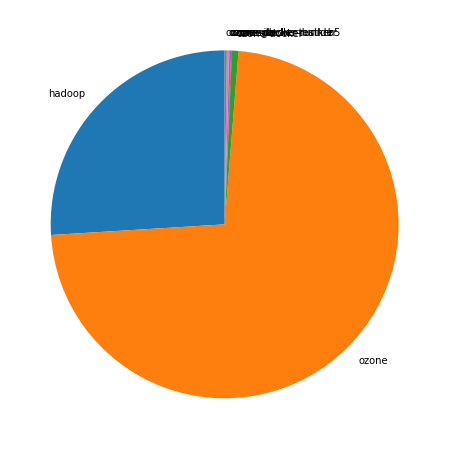

In [7]:
labels = np.asarray(per_repo["repo"])
plt.figure(figsize=(10,8))
plt.pie(per_repo["ratio"], labels=labels, startangle=90)
plt.show()

# Github Contributions per user


In [8]:
c = contributions[["identifier","author","type","owner"]].groupby(["author","type","owner"]).count() \
   .reset_index().rename(columns={"identifier":"contributions"})
#contributions per user
c[c.author != c.owner][["author","contributions"]].groupby("author").sum().sort_values("contributions",ascending=False).head(10)


,contributions
author,
bharatviswa504,1917
xiaoyuyao,1577
adoroszlai,1370
elek,1283
arp7,705
anuengineer,608
bshashikant,560
avijayanhwx,423
dineshchitlangia,376


## Contributors per participations in PRs which are not created by self (helping PRs)

In [9]:
c = contributions[contributions.author != contributions.owner][["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

,identifier
author,
adoroszlai,611
elek,556
bharatviswa504,446
xiaoyuyao,396
anuengineer,297
arp7,262
bshashikant,215
avijayanhwx,182
mukul1987,172


## Contributors per participations in any PRs

In [10]:
c = contributions[["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

,identifier
author,
adoroszlai,953
elek,845
bharatviswa504,687
xiaoyuyao,472
bshashikant,306
anuengineer,306
avijayanhwx,300
arp7,273
mukul1987,237


# Bus factor (number of contributors responsible for the 50% of the prs) from last half year

## Contributors until the half of the all contributions (last 6 month)

In [11]:
prcreated = contributions[contributions.type == "PR_CREATED"]
prcreated = prcreated[prcreated.date > (datetime.datetime.now() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')]
prcreated = prcreated[["identifier"]].groupby(prcreated.author).count().reset_index()
prcreated = prcreated.sort_values("identifier", ascending=False)
prcreated = prcreated.reset_index(drop=True)
prcreated["cs"] = prcreated["identifier"].cumsum()
prcreated["ratio"]= prcreated.identifier / prcreated.identifier.sum()  * 100
prcreated[prcreated.cs < prcreated.identifier.sum() / 2]

,author,identifier,cs,ratio
0,adoroszlai,83,83,12.462462
1,elek,70,153,10.510511
2,bharatviswa504,43,196,6.456456
3,GlenGeng,42,238,6.306306
4,rakeshadr,32,270,4.804805
5,amaliujia,25,295,3.753754
6,bshashikant,24,319,3.603604


## Pony number (bus factor)

In [12]:
pn = (prcreated[prcreated.cs < prcreated.identifier.sum() / 2]).shape[0] + 1
pn

8

## Dev power (All the contributions in the ration of the top contributor)

In [13]:
prcreated["power"] = prcreated["identifier"] / prcreated.reset_index()["identifier"][0] 
prcreated.power.sum()

8.024096385542169

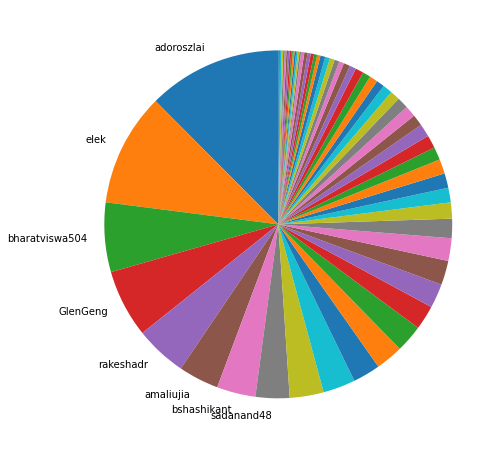

In [14]:
labels = np.asarray(prcreated["author"])
for i in range(pn,len(labels)):
    labels[i] = ""
plt.figure(figsize=(10,8))
plt.pie(prcreated["ratio"], labels=labels, startangle=90)
plt.show()


## People with created PRs > reviewed/commented PRS

In [15]:
created = contributions[contributions.type == "PR_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = contributions[contributions.author != contributions.owner][["identifier"]].groupby([contributions.author,contributions.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created, left_index=True, right_index=True)

merged.index = merged.index.rename("githubid")
merged = merged.join(github_apache_membership.set_index("githubid")).reset_index()
merged.role = merged.role.fillna("?")
merged["rc"] = merged.role.map({"pmc":"red","committer":"yellow","?":"blue"})


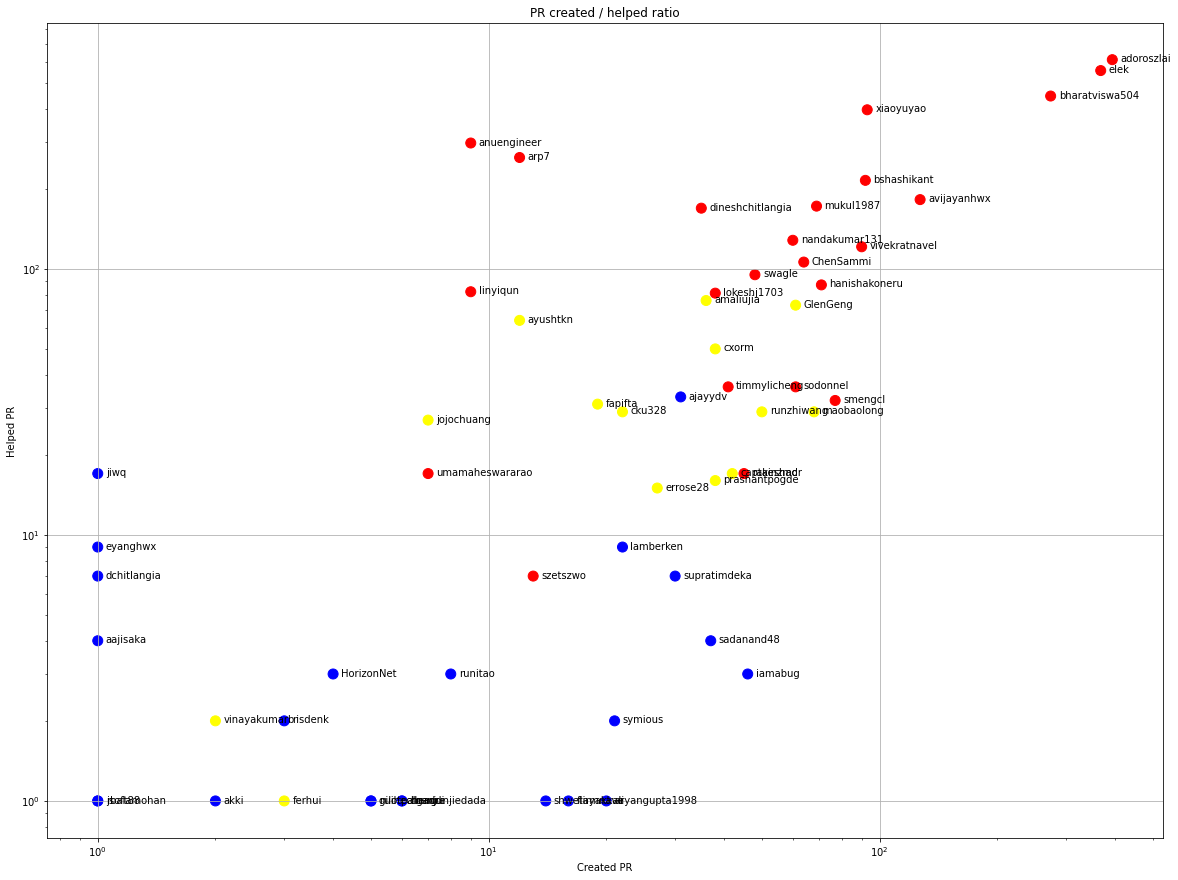

In [16]:
source = merged.reset_index()

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped,color=source.rc, s= 100)

plt.xlabel('Created PR')
plt.ylabel('Helped PR')
plt.title('PR created / helped ratio')
plt.grid()

for index, row in source.iterrows():
     plt.annotate(row["githubid"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
plt.semilogx()
plt.semilogy()
plt.show()

## Same graph with focusing to the last 6 month

Only contributors with both created pr and helped pr visible

In [17]:
import datetime

filtered = contributions[contributions.date > (datetime.datetime.now() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')]
created = filtered[filtered.type == "PR_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = filtered[filtered.author != filtered.owner][["identifier"]].groupby([filtered.author,filtered.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created,left_index=True, right_index=True)

merged.index = merged.index.rename("githubid")
merged = merged.join(github_apache_membership.set_index("githubid")).reset_index()
merged.role = merged.role.fillna("?")
merged["rc"] = merged.role.map({"pmc":"red","committer":"yellow","?":"blue"})
merged = merged.fillna(0)

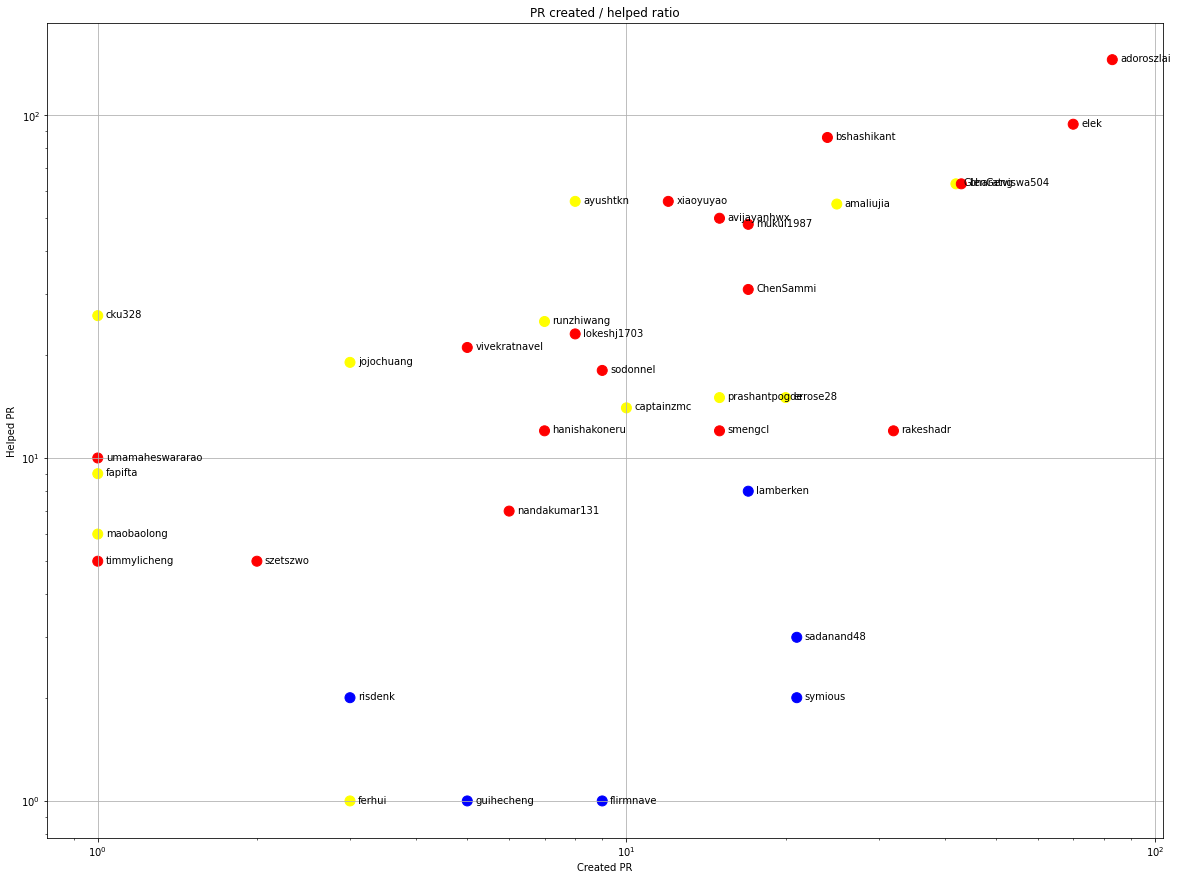

In [18]:
source = merged.reset_index()

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped,color=source.rc, s= 100)

plt.xlabel('Created PR')
plt.ylabel('Helped PR')
plt.title('PR created / helped ratio')
plt.grid()

for index, row in source.iterrows():
    plt.annotate(row["githubid"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
        
plt.semilogx()
plt.semilogy()
plt.show()


# Number of individual contributors per month

Number of different Github users who either created PR, commented PR, added review to a PR

Note: only events from apache/hadoop-ozone repository are included. Earlier PRs/comments are not here.

In [19]:
m = contributions[["identifier"]].groupby([contributions.date.dt.strftime('%Y').rename("year"),contributions.date.dt.strftime('%m').rename("month"),contributions.author]).count() \
  .reset_index()
result = m[["author"]].groupby([m.year,m.month]).count().sort_values(["year","month"]).reset_index()
result = result.pivot(index="year",columns="month",values="author").fillna(0)
result

month,01,02,03,04,05,06,07,08,09,10,11,12
year,,,,,,,,,,,,
2019,2.0,14.0,19.0,19.0,24.0,23.0,28.0,28.0,28.0,33.0,35.0,34.0
2020,31.0,32.0,37.0,40.0,44.0,48.0,46.0,39.0,45.0,40.0,46.0,42.0
2021,47.0,45.0,48.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


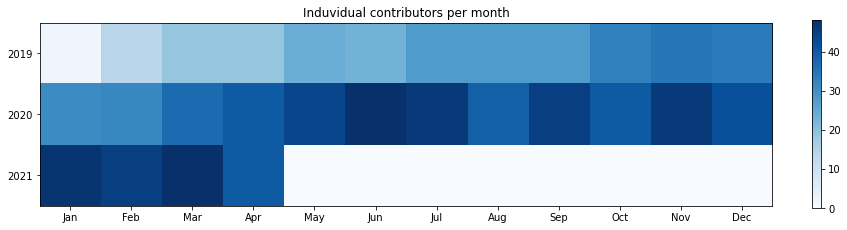

In [20]:
plt.figure(figsize=(14,11))
im = plt.imshow(result, cmap="Blues")
plt.yticks(range(len(result)),result.index.values)
plt.xticks(range(12), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title("Induvidual contributors per month")
plt.colorbar(im, fraction=0.012)
plt.show()


# Number of PRs closed/created per month

In [21]:
a = contributions[contributions.type.isin(["PR_CREATED","PR_MERGED"])]
a = a[["identifier"]].groupby([a.date.dt.to_period("M"),a.type]).count().reset_index()
a = a.pivot(index="date",columns="type",values="identifier")
a.sort_values("date",ascending=False).head(10)
a.columns = ["created","merged"]
a = a.reset_index()

/usr/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


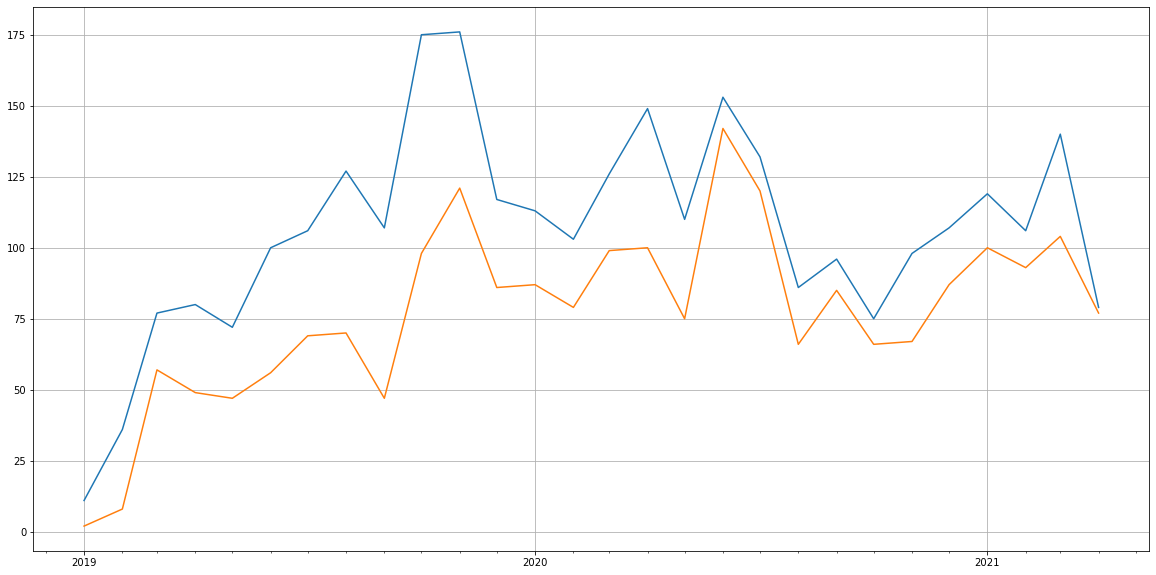

In [22]:
a['d'] = a['date'].apply(pd.Period.to_timestamp)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot('d', 'created', data=a)
ax.plot('d', 'merged', data=a)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.grid(True)

plt.show()

# PR activity heatmap

In [23]:
days = contributions.date.dt.strftime('%A')
hours = contributions.date.dt.strftime('%H')

a = contributions[["date"]].groupby([days,hours]).count()
a.columns = ["count"]
a.index.names = ["day","hour"]
a = a.reset_index()
a = a.pivot(index="day",columns="hour",values="count")
a = a.reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])


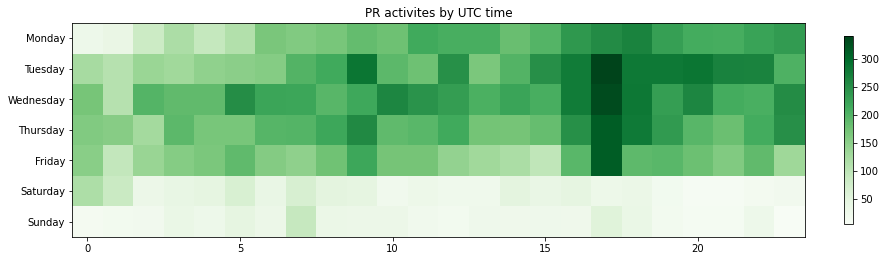

In [24]:
plt.figure(figsize=(14,11))
im = plt.imshow(a, cmap="Greens")
plt.yticks(range(len(a)),a.index.values)
plt.title("PR activites by UTC time")
plt.colorbar(im, fraction=0.012)
plt.show()


## Created PR per month

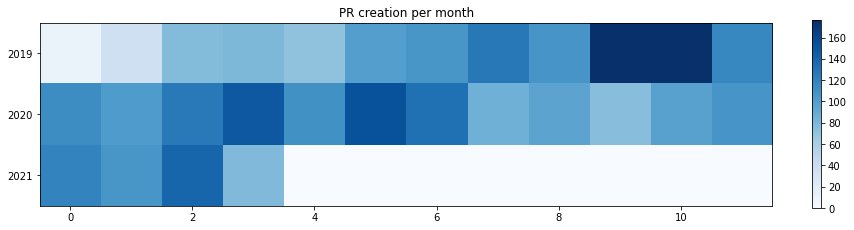

In [25]:

pr_created = contributions[contributions.type == "PR_CREATED"]
result = pr_created[["identifier"]].groupby([pr_created.date.dt.strftime('%Y').rename("year"),pr_created.date.dt.strftime('%m').rename("month")]).count() \
  .reset_index()
result = result.pivot(index="year",columns="month",values="identifier").fillna(0)
result

plt.figure(figsize=(14,11))
im = plt.imshow(result, cmap="Blues")
plt.yticks(range(len(result)),result.index.values)
plt.title("PR creation per month")
plt.colorbar(im, fraction=0.012)
plt.show()
